# Import Dependencies
------

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM
-----------

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# create inspector
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model and reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis
------

In [10]:
# Find columns in table
columns=inspector.get_columns('measurement')
for c in columns:
    print (c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
mm_latest_date = engine.execute('select date from measurement order by date desc;').fetchone()
mm_latest_date

('2017-08-23',)

In [12]:
# Find the most recent date in the data set another way.
mm_latest_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
mm_latest_date

('2017-08-23',)

### Query and Plot the Last 12 Months of Precipitation Data 
----- 

In [13]:
# Calculate the date one year from the last date in data set.
mm_yr_back = dt.date(2017,8,23) - dt.timedelta(days=365)
mm_yr_back

datetime.date(2016, 8, 23)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data
mm_latest_yr = session.query( measurements.date, measurements.prcp).filter(measurements.date > (dt.date(2016, 8, 23))).all()

In [15]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names.
mm_latest_yr_df = pd.DataFrame(mm_latest_yr).rename(columns = {0:"Date",1:"Percipitation (Inches)"})

# Sort the dataframe by date
mm_latest_yr_df = mm_latest_yr_df.sort_values("Date").reset_index(drop=True)


# Display the dataframe
mm_latest_yr_df.head()


,Date,Percipitation (Inches)
0,2016-08-24,0.08
1,2016-08-24,NaN
2,2016-08-24,2.15
3,2016-08-24,2.28
4,2016-08-24,2.15


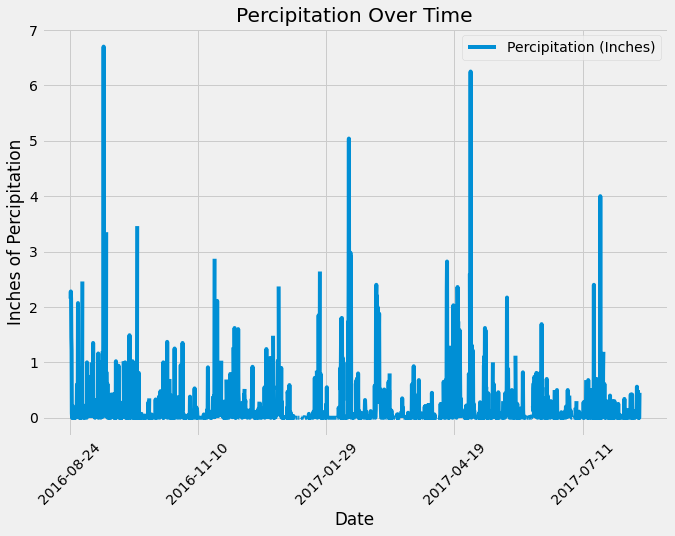

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
mm_latest_yr_df.plot('Date','Percipitation (Inches)', figsize=(10, 7))
plt.title("Percipitation Over Time")
plt.xlabel("Date")
plt.ylabel("Inches of Percipitation")
plt.xticks(rotation=45)
plt.show()


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
mm_latest_yr_df.describe()

,Percipitation (Inches)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis
-----

In [18]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(measurements.station).distinct().count()
station_count

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations_activity = session.query(measurements.station, func.count(measurements.station)).group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
stations_activity 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
USC00519281_stats = session.query(func.min(measurements.tobs), func.max(measurements.tobs),func.avg(measurements.tobs)).filter_by(station = 'USC00519281').all()

USC00519281_stats

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Find the most recent date in the data set.
USC00519281_latest_date = session.query(measurements.date).filter_by(station = 'USC00519281').order_by(measurements.date.desc()).first()
USC00519281_latest_date

('2017-08-18',)

In [22]:
# Calculate the date one year from the last date in data set.
USC00519281_yr_back = dt.date(2017,8,18) - dt.timedelta(days=365)
USC00519281_yr_back

datetime.date(2016, 8, 18)

In [23]:
# Using the most active station id, query the last 12 months of temperature observation data for this station
USC00519281_last_yr = session.query(measurements.tobs).filter(measurements.date > (dt.date(2016, 8, 18))).filter_by(station="USC00519281").order_by(measurements.date).all()

# Create a dataframe
USC00519281_last_yr_df = pd.DataFrame(USC00519281_last_yr).rename(columns = {0:"Temperature (F)"})
USC00519281_last_yr_df.head()

,Temperature (F)
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0


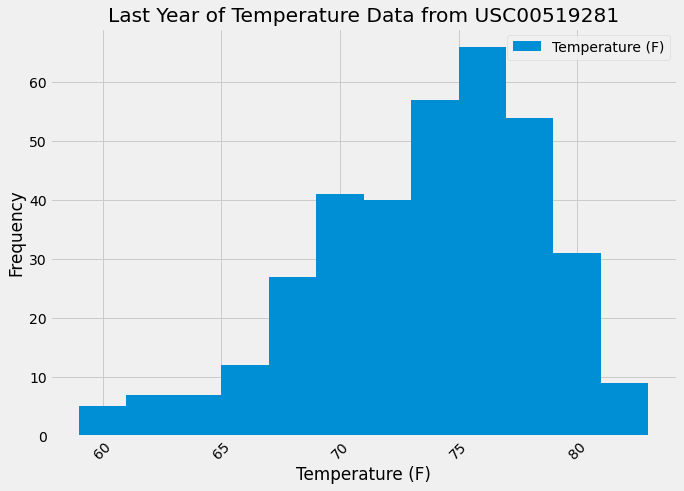

In [24]:
# Plot the results as a histogram
USC00519281_last_yr_df.plot(kind="hist", bins=12, figsize=(10, 7))
plt.title("Last Year of Temperature Data from USC00519281")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Close Session

In [25]:
# Close Session
session.close()